# 전처리와 KNN (K-Nearest Neighbors)

지금까지는 깨끗한 데이터만 써왔는데, 실제로는 더러운 데이터가 대부분이다. 이제 진짜 전처리를 배워보자.

이 장에서 여러분은 실제 데이터의 문제점을 파악하고 해결하는 전처리 과정과 KNN 알고리즘을 배운다. 구체적인 내용은 다음 세 가지이다.

1. **전처리(Preprocessing)**: 결측치 처리와 데이터 정제
2. **KNN 모델 훈련과 사용, 평가**: 거리 기반 분류 알고리즘
3. **시각화**: PCA 차원축소를 통한 분류 결과 시각화

## 1. 전처리 (Preprocessing)

실제 데이터는 대부분 더럽다. 결측치가 있고, 이상치가 있고, 형식이 맞지 않는다. 이런 문제를 해결하는 과정이 전처리다. 

전처리 과정은 다음과 같다:
1. 데이터 탐색으로 문제점 파악하기
2. 결측치 처리 전략 결정하기
3. 범주형 데이터를 숫자로 변환하기

### 1.1. 데이터 탐색과 문제점 파악

실제 데이터셋을 로드해서 어떤 문제가 있는지 살펴보자. 결측치가 어느 열에 얼마나 있는지 파악하는 것이 첫 번째 단계다.

In [1]:
import seaborn as sns

# 실제 더러운 데이터 로드
titanic = sns.load_dataset('titanic')
titanic

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [2]:
# 데이터 길이와 유효값 개수를 열별로 확인
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [3]:
# 열별 결측치 개수 확인
titanic.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [4]:
# 결측치가 있는 열 찾기 - 뭘 반환하는지 살펴보기
titanic.isna().sum() > 0

survived       False
pclass         False
sex            False
age             True
sibsp          False
parch          False
fare           False
embarked        True
class          False
who            False
adult_male     False
deck            True
embark_town     True
alive          False
alone          False
dtype: bool

In [5]:
# 결측치가 있는 열만 추출
titanic.isna().sum()[titanic.isna().sum() > 0]

age            177
embarked         2
deck           688
embark_town      2
dtype: int64

In [6]:
clean_titanic = titanic.copy()

#### Practice1. 다른 데이터셋도 탐색해보기

1. `titanic` 데이터셋의 결측치가 어느 열에 얼마나 있는지 확인하기 (복습)
2. `penguins` 데이터셋을 로드해서 결측치가 있는 열과 개수를 확인하기

In [7]:
# penguins 데이터셋 탐색
penguins = sns.load_dataset('penguins')
penguins.isna().sum()[penguins.isna().sum() > 0]

bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

### 1.2. 결측치 처리 전략

앞서 본 titanic 데이터셋에서 결측치가 나오는 열을 기준으로 적당한 처리 전략을 결정해보자. 열을 드롭해버리거나, 평균값이나 최빈값으로 채우는 방법이 있다.

In [8]:
titanic = sns.load_dataset('titanic')

In [11]:
mean_age = titanic['age'].mean()
titanic['age'] = titanic['age'].fillna(mean_age)

In [12]:
titanic['embarked'].tail(), titanic['embark_town'].tail()

(886    S
 887    S
 888    S
 889    C
 890    Q
 Name: embarked, dtype: object,
 886    Southampton
 887    Southampton
 888    Southampton
 889      Cherbourg
 890     Queenstown
 Name: embark_town, dtype: object)

In [13]:
titanic.drop(columns=['embarked'], inplace=True)

In [15]:
freq = titanic['embark_town'].mode()[0]
titanic['embark_town'] = titanic['embark_town'].fillna(freq)

In [16]:
titanic.drop(columns=['deck'], inplace=True)

In [17]:
clean_titanic = titanic.copy()
clean_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          891 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   class        891 non-null    category
 8   who          891 non-null    object  
 9   adult_male   891 non-null    bool    
 10  embark_town  891 non-null    object  
 11  alive        891 non-null    object  
 12  alone        891 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(4)
memory usage: 72.5+ KB


#### Practice2. `penguins`에서도 결측치 처리하기

`penguins` 데이터셋에서 결측치를 적절한 전략으로 처리해보자.

In [ ]:
# penguins 결측치 처리
penguins = sns.load_dataset('penguins')
penguins.info()

penguins.dropna(inplace=True)

penguins.isna().sum()[penguins.isna().sum() > 0]

In [ ]:
clean_penguins = penguins.copy()
clean_penguins.to_csv('clean_penguins.csv')

### 1.3. 범주형 데이터 숫자 변환 (LabelEncoder 복습)

5차시에서 배운 LabelEncoder를 사용해서 범주형 데이터를 숫자로 변환하자. 머신러닝 모델은 숫자만 이해할 수 있기 때문이다.

In [19]:
from sklearn.preprocessing import LabelEncoder

encoders = {}
str_cols = ['sex', 'class', 'who', 'adult_male', 'embark_town', 'alive', 'alone']

for colname in str_cols:
    le = LabelEncoder()
    le.fit(clean_titanic[colname])
    encoders[colname] = le
    clean_titanic[colname] = le.transform(clean_titanic[colname])

clean_titanic

,survived,pclass,sex,age,sibsp,parch,fare,class,who,adult_male,embark_town,alive,alone
0,0,3,1,22.000000,1,0,7.2500,2,1,1,2,0,0
1,1,1,0,38.000000,1,0,71.2833,0,2,0,0,1,0
2,1,3,0,26.000000,0,0,7.9250,2,2,0,2,1,1
3,1,1,0,35.000000,1,0,53.1000,0,2,0,2,1,0
4,0,3,1,35.000000,0,0,8.0500,2,1,1,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.000000,0,0,13.0000,1,1,1,2,0,1
887,1,1,0,19.000000,0,0,30.0000,0,2,0,2,1,1
888,0,3,0,29.699118,1,2,23.4500,2,2,0,2,0,0
889,1,1,1,26.000000,0,0,30.0000,0,1,1,0,1,1


In [20]:
clean_titanic.to_csv('preprocessed_titanic.csv')

#### Practice3. `preprocessed_titanic`, `preprocessed_penguins` 생성하기

전처리 완료된 깨끗한 데이터셋 두 개를 만들어서 나중에 KNN 실습에 사용하자.

In [ ]:
# 1. clean_titanic 생성 (이미 처리 완료)
clean_titanic = titanic.copy()
print("✅ clean_titanic 생성 완료")
print(f"   크기: {clean_titanic.shape}")
print(f"   결측치: {clean_titanic.isna().sum().sum()}개")
print()

# 2. clean_penguins 생성
clean_penguins = penguins_clean.copy()
# penguins의 문자열 컬럼들도 변환
penguin_text_cols = ['species', 'island', 'sex']
for col in penguin_text_cols:
    if col in clean_penguins.columns:
        le = LabelEncoder()
        clean_penguins[col] = le.fit_transform(clean_penguins[col])

print("✅ clean_penguins 생성 완료")
print(f"   크기: {clean_penguins.shape}")
print(f"   결측치: {clean_penguins.isna().sum().sum()}개")
print()

In [ ]:
# 전처리 완료된 데이터 미리보기
print("=== clean_titanic ===")
print(clean_titanic.head())
print()

print("=== clean_penguins ===")
print(clean_penguins.head())
print()


## 2. KNN 모델 훈련과 사용, 평가

이제 전처리가 완료된 깨끗한 데이터로 KNN(K-Nearest Neighbors) 알고리즘을 배워보자. KNN은 가장 직관적인 분류 알고리즘 중 하나다.

### 2.1. KNN 기본 개념과 원리

KNN은 "가장 가까운 이웃들의 투표로 분류하는 직관적인 방법"이다. 

**원리:**
- 새로운 데이터가 들어오면, 가장 가까운 K개의 이웃을 찾는다
- 그 K개 이웃들이 어떤 클래스인지 확인한다
- 다수결로 새로운 데이터의 클래스를 결정한다

**K값의 의미:**
- K=1: 가장 가까운 1개만 보고 결정 (과적합 위험)
- K=3: 가장 가까운 3개를 보고 다수결로 결정
- K=5: 가장 가까운 5개를 보고 다수결로 결정
- K가 클수록 안정적이지만, 너무 크면 경계가 뭉뚱그려짐
- **홀수 추천**: 동점을 피하기 위해

#### Practice1. K값 변화에 따른 영향 생각해보기

만약 당신이 새로운 동네로 이사를 왔다고 생각해보자:
- K=1: 바로 옆집 1명만 보고 이 동네 분위기를 판단
- K=5: 가장 가까운 5집을 보고 판단  
- K=50: 가장 가까운 50집을 보고 판단

어떤 K값이 가장 정확할까? 왜 그럴까?

### 2.2. KNN 모델 선언과 학습

이제 실제로 KNN 모델을 만들어보자. 원본 고차원 데이터로 모델을 학습시키는 것이 중요하다.

모델 정확도: 0.7262569832402235


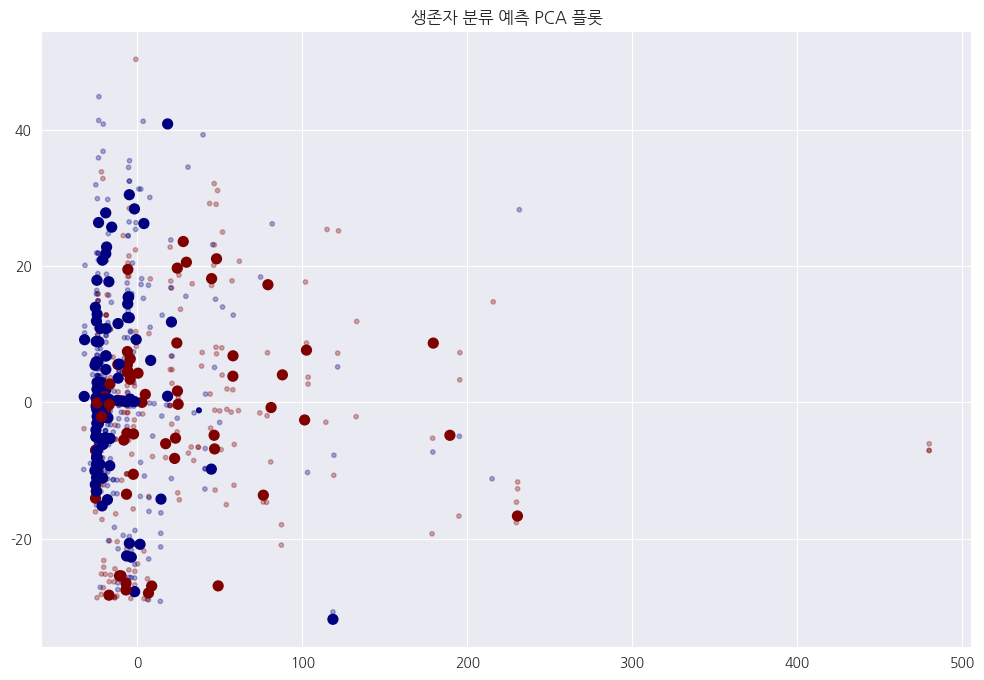

In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

x = clean_titanic.iloc[:, 1:]
y = clean_titanic.iloc[:, 0]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)
knn = KNeighborsClassifier(n_neighbors=5)  # 모델 선언
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print("모델 정확도:", acc)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

import matplotlib.pyplot as plt
import koreanize_matplotlib
plt.figure(figsize=(12, 8))
plt.title("생존자 분류 예측 PCA 플롯")
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train,
            label="훈련 데이터", cmap='jet', s=10, alpha=.3)
plt.scatter(x_test_pca[:, 0], x_test_pca[:, 1], c=y_pred,
            label="테스트 데이터", cmap='jet', s=50)
plt.show()


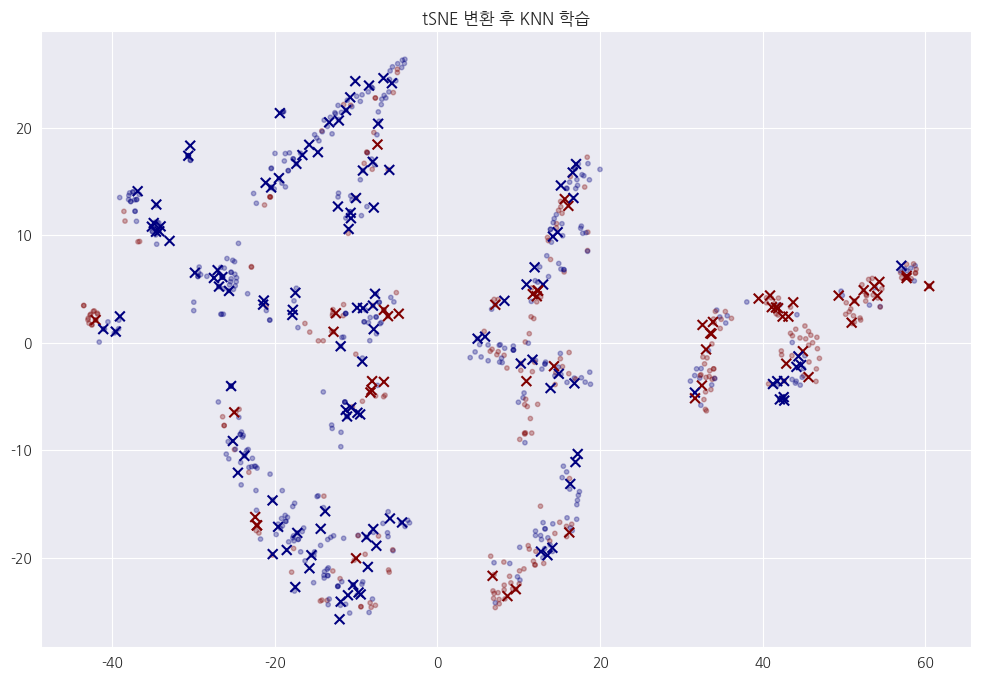

In [63]:
x = clean_titanic.iloc[:, 1:]
y = clean_titanic.iloc[:, 0]

# tSNE 변환
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(tsne_results, y, test_size=.2)

knn_tsne = KNeighborsClassifier(n_neighbors=5)
knn_tsne.fit(x_train, y_train)
y_pred = knn_tsne.predict(x_test)

# 시각화
plt.figure(figsize=(12, 8))
plt.title('tSNE 변환 후 KNN 학습')
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train,
            label='훈련 데이터', s=10, alpha=.3, cmap='jet')
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_pred,
            label='테스트 데이터', s=50, marker='x', cmap='jet')

In [65]:
accuracy_score(y_test, y_pred)

0.6815642458100558

In [24]:
# 훈련용과 테스트용으로 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(f"훈련용 데이터: {X_train.shape[0]}개")
print(f"테스트용 데이터: {X_test.shape[0]}개")

훈련용 데이터: 712개
테스트용 데이터: 179개


In [25]:
# KNN 모델 선언과 학습
model = KNeighborsClassifier(n_neighbors=5)  # K=5로 설정
model.fit(X_train, y_train)

# 예측 수행
y_pred = model.predict(X_test)

print("KNN 모델 학습 완료!")
print(f"K값: {model.n_neighbors}")
print(f"예측 결과 예시: {y_pred[:10]}")
print(f"실제 결과 예시: {y_test.iloc[:10].values}")

KNN 모델 학습 완료!
K값: 5
예측 결과 예시: [0 0 0 0 1 0 0 1 1 0]
실제 결과 예시: [0 1 0 0 0 1 0 0 1 0]


#### Practice2. K값을 바꿔가며 성능 비교하기

K=1, K=3, K=7, K=15로 바꿔가며 어떤 K값이 가장 좋은 성능을 보이는지 확인해보자.

In [26]:
from sklearn.metrics import accuracy_score

# 여러 K값으로 성능 비교
k_values = [1, 3, 5, 7, 15]
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_k = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_k)
    accuracies.append(accuracy)
    print(f"K={k}: 정확도 {accuracy:.3f}")

# 최고 성능 K값 찾기
best_k = k_values[accuracies.index(max(accuracies))]
print(f"\n🏆 최고 성능: K={best_k}, 정확도 {max(accuracies):.3f}")

K=1: 정확도 0.659
K=3: 정확도 0.687
K=5: 정확도 0.665
K=7: 정확도 0.676
K=15: 정확도 0.676

🏆 최고 성능: K=3, 정확도 0.687


### 2.3. KNN 모델 평가 (복습)

ML 4차시에서 배운 평가 방법들을 복습해보자. 코드와 결과만 간단히 확인하면 된다.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 최고 성능 K값으로 최종 모델 생성
final_model = KNeighborsClassifier(n_neighbors=best_k)
final_model.fit(X_train, y_train)
final_pred = final_model.predict(X_test)

# 1. accuracy_score
accuracy = accuracy_score(y_test, final_pred)
print(f"정확도: {accuracy:.3f}")
print()

# 2. classification_report
print("분류 리포트:")
print(classification_report(y_test, final_pred))
print()

# 3. confusion_matrix
print("혼동 행렬:")
print(confusion_matrix(y_test, final_pred))

#### Practice3. clean_penguins, clean_diamonds로도 KNN 실습하기

다른 데이터셋으로도 KNN을 실습해보자.
- penguins: 종(species) 분류
- diamonds: 등급(cut) 분류

In [ ]:
# 1. clean_penguins로 종 분류
X_penguin = clean_penguins[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
y_penguin = clean_penguins['species']

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_penguin, y_penguin, test_size=0.2, random_state=42)

knn_penguin = KNeighborsClassifier(n_neighbors=5)
knn_penguin.fit(X_train_p, y_train_p)
y_pred_p = knn_penguin.predict(X_test_p)

print("🐧 Penguins 종 분류 결과:")
print(f"정확도: {accuracy_score(y_test_p, y_pred_p):.3f}")
print()

## 3. 시각화

제일 중요하다. 그래프를 그릴 줄 알아야 한다. 이번에는 KNN 분류 결과를 시각화해보자.

### 3.1. KNN 결과 시각화

PCA 차원축소는 시각화 목적으로만 사용한다. 모델 학습은 원본 데이터로, 시각화만 2차원으로 축소해서 보여준다.

In [ ]:
import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.decomposition import PCA

# PCA로 2차원 축소 (시각화 목적으로만)
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# 분류 결과 시각화
plt.figure(figsize=(12, 5))

# 왼쪽: 실제값
plt.subplot(1, 2, 1)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='viridis', alpha=0.7)
plt.title('실제 생존 여부')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} 설명)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} 설명)')
plt.colorbar(label='생존(1) vs 사망(0)')

# 오른쪽: 예측값
plt.subplot(1, 2, 2)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=final_pred, cmap='viridis', alpha=0.7)
plt.title(f'KNN 예측 결과 (K={best_k})')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} 설명)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} 설명)')
plt.colorbar(label='생존(1) vs 사망(0)')

plt.tight_layout()
plt.show()

In [ ]:
# K값에 따른 정확도 변화 그래프
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, 'bo-', linewidth=2, markersize=8)
plt.title('K값에 따른 KNN 성능 변화')
plt.xlabel('K값')
plt.ylabel('정확도')
plt.grid(True, alpha=0.3)

# 최고 성능 K값 표시
plt.axvline(best_k, color='red', linestyle='--', alpha=0.7, label=f'최고 성능 K={best_k}')
plt.legend()

# 각 점에 정확도 값 표시
for k, acc in zip(k_values, accuracies):
    plt.annotate(f'{acc:.3f}', (k, acc), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

In [ ]:
# 혼동행렬 히트맵 시각화
import seaborn as sns

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, final_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['사망', '생존'], yticklabels=['사망', '생존'])
plt.title(f'혼동행렬 (K={best_k})')
plt.xlabel('예측값')
plt.ylabel('실제값')
plt.show()

print(f"정확도: {accuracy:.3f}")
print(f"총 {len(y_test)}명 중 {(final_pred == y_test).sum()}명 정확히 예측")

#### Practice4. 세 데이터셋 모두 시각화하기

penguins와 diamonds 데이터도 PCA로 차원축소해서 분류 결과를 시각화해보자.

In [ ]:
# 세 데이터셋 모두 시각화
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Titanic 시각화
pca_titanic = PCA(n_components=2)
X_test_titanic_pca = pca_titanic.fit_transform(X_test)

axes[0, 0].scatter(X_test_titanic_pca[:, 0], X_test_titanic_pca[:, 1], c=y_test, cmap='viridis', alpha=0.7)
axes[0, 0].set_title('Titanic 실제값')
axes[1, 0].scatter(X_test_titanic_pca[:, 0], X_test_titanic_pca[:, 1], c=final_pred, cmap='viridis', alpha=0.7)
axes[1, 0].set_title(f'Titanic 예측값 (정확도: {accuracy:.3f})')

# 2. Penguins 시각화
pca_penguin = PCA(n_components=2)
X_test_penguin_pca = pca_penguin.fit_transform(X_test_p)

axes[0, 1].scatter(X_test_penguin_pca[:, 0], X_test_penguin_pca[:, 1], c=y_test_p, cmap='viridis', alpha=0.7)
axes[0, 1].set_title('Penguins 실제값')
axes[1, 1].scatter(X_test_penguin_pca[:, 0], X_test_penguin_pca[:, 1], c=y_pred_p, cmap='viridis', alpha=0.7)
axes[1, 1].set_title(f'Penguins 예측값 (정확도: {accuracy_score(y_test_p, y_pred_p):.3f})')

# 3. Diamonds 시각화
pca_diamond = PCA(n_components=2)
X_test_diamond_pca = pca_diamond.fit_transform(X_test_d)

axes[0, 2].scatter(X_test_diamond_pca[:, 0], X_test_diamond_pca[:, 1], c=y_test_d, cmap='viridis', alpha=0.7)
axes[0, 2].set_title('Diamonds 실제값')
axes[1, 2].scatter(X_test_diamond_pca[:, 0], X_test_diamond_pca[:, 1], c=y_pred_d, cmap='viridis', alpha=0.7)
axes[1, 2].set_title(f'Diamonds 예측값 (정확도: {accuracy_score(y_test_d, y_pred_d):.3f})')

plt.tight_layout()
plt.show()

print("🎉 ML 6. 전처리와 KNN 완료!")
print("배운 내용:")
print("1. 실제 데이터의 결측치 탐색과 처리")
print("2. LabelEncoder로 문자열을 숫자로 변환")
print("3. KNN 알고리즘으로 분류 수행")
print("4. PCA 차원축소를 통한 시각화")